In [1]:
#!pip install tf-agents[reverb]
#!pip install keras-rl2
!pip install setuptools==65.5.0
!pip install stable-baselines3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.6.1
    Uninstalling setuptools-67.6.1:
      Successfully uninstalled setuptools-67.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
cvxpy 1.3.1 requires setuptools>65.5.1, but you have setuptools 65.5.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 50.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-ex

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/2_environments_tutorial.ipynb#scrollTo=zfF8koryiGPR

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

#from rl.agents.dqn import DQNAgent
#from rl.policy import EpsGreedyQPolicy
#from rl.memory import SequentialMemory

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np
import pandas as pd
import gym
import random as rand
from collections import deque

from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
#from tensorflow.keras import layers

#from tf_agents.environments import py_environment
#from tf_agents.environments import tf_environment
#from tf_agents.environments import tf_py_environment
#from tf_agents.environments import utils
#from tf_agents.specs import array_spec
#from tf_agents.environments import wrappers
#from tf_agents.environments import suite_gym
#from tf_agents.trajectories import time_step as ts

import math
from sklearn.preprocessing import MinMaxScaler

from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

https://blog.quantinsti.com/sharpe-ratio-applications-algorithmic-trading/

https://colab.research.google.com/github/tatsath/fin-ml/blob/master/Chapter%209%20-%20Reinforcement%20Learning/Case%20Study%203%20-%20Portfolio%20Allocation/PortfolioAllocation.ipynb#scrollTo=0g_MWu6e0lL9

In [53]:
AAPL=pd.read_csv('/content/drive/MyDrive/data/DAILY_DATA/AAPL (1).csv')#[1:]
BND=pd.read_csv('/content/drive/MyDrive/data/DAILY_DATA/BND (2).csv')#[:-1]
GLD=pd.read_csv('/content/drive/MyDrive/data/DAILY_DATA/GLD (1).csv')#[1:]
R2K=pd.read_csv('/content/drive/MyDrive/data/DAILY_DATA/IWM.csv')#[1:]
XLE=pd.read_csv('/content/drive/MyDrive/data/DAILY_DATA/XLE (1).csv')#[:-1]
JPM=pd.read_csv('/content/drive/MyDrive/data/DAILY_DATA/JPM.csv')#[:-1]
SPY=pd.read_csv('/content/drive/MyDrive/data/DAILY_DATA/SPY (4).csv')#[1:]
USGB=pd.read_excel('/content/drive/MyDrive/data/portfolio_index/USGB.xlsx')

In [70]:
AAPL

,Open,High,Low,Close,Adj Close,Volume,LogReturn,Variance5D,RealizedVol5D
Date,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099722,469033600,NaN,NaN,NaN
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094519,175884800,-5.358544,1.111111e+09,1.111111e+09
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087581,105728000,-7.623679,1.111111e+09,1.111111e+09
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089749,86441600,2.445281,1.111111e+09,1.111111e+09
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092351,73449600,2.857965,1.111111e+09,1.111111e+09
...,...,...,...,...,...,...,...,...,...
2023-04-06,162.429993,164.960007,162.000000,164.660004,164.660004,45390100,0.548086,5.361990e+00,2.315597e+00
2023-04-10,161.419998,162.029999,160.080002,162.029999,162.029999,47716900,-1.610127,4.693876e+00,2.166535e+00
2023-04-11,162.350006,162.360001,160.509995,160.800003,160.800003,47644200,-0.762012,4.876720e+00,2.208330e+00


In [54]:
# FOR REFERENCE
assets=[SPY,AAPL,GLD,R2K,JPM,XLE,BND]
assetNames=['SPY','AAPL','GLD','R2K','JPM','XLE','BND']
# ADDING DAILY PERFORMANCE
def addDaily(etf,indexName):
  asset=etf
  asset['LogReturn']=100*np.log(asset['Adj Close']/(asset['Adj Close'].shift()))
  asset['Adj Close']=asset['Adj Close']
  asset['Variance5D']=asset['LogReturn']+1111111111
  asset['RealizedVol5D']=asset['LogReturn']+1111111111
  for i in range(6,len(asset)):
    series=asset.iloc[i-5:i,7]
    var,vol=realizedVol(series.values)
    asset['Variance5D'].iloc[i]=var
    asset['RealizedVol5D'].iloc[i]=vol
  return asset

def realizedVol(series):
  var=np.sum(series**2)
  vol=np.sqrt(var)
  return var,vol

assets2=[]
for i in range(len(assets)):
  asset=assets[i]
  indexName=assetNames[i]
  asset=addDaily(asset,indexName)
  asset.index=pd.to_datetime(asset.Date)
  asset=asset.drop('Date',axis=1,inplace=True)
  assets2.append(asset)

In [55]:
assets2[0]

In [56]:
USGB=USGB[6:];
USGB['Security']=USGB['Security'].astype(str).str[:-9];
USGB=USGB.rename(columns={'Security':'Date',
                            'USGB360D Index                                                  ':'USGB3260D'})
USGB.index=pd.to_datetime(USGB.Date)
USGB['RisklessRate1D']=1+(USGB['USGB3260D']/100).astype(float)
USGB['RisklessRate1D']=np.log(USGB['RisklessRate1D'])/255*100
USGB=USGB.drop('Date',axis=1)
USGB.dropna(inplace=True)
USGB

,USGB3260D,RisklessRate1D
Date,,
2023-03-24,4.09364,0.015734
2023-03-23,4.08525,0.015702
2023-03-22,4.18976,0.016096
2023-03-21,4.27056,0.016400
2023-03-20,4.21378,0.016186
...,...,...
2008-08-20,1.93467,0.007514
2008-08-19,1.95365,0.007587
2008-08-18,1.99433,0.007744


In [57]:
assetNames

['SPY', 'AAPL', 'GLD', 'R2K', 'JPM', 'XLE', 'BND']

In [58]:
data=pd.DataFrame()
data=USGB.drop('USGB3260D',axis=1)
data['SPY-Variance']=SPY['Variance5D']
etfs=[SPY,AAPL,GLD,R2K,JPM,XLE,BND]
etfNames=['SPY','AAPL','GLD','R2K','JPM','XLE','BND']
for i in range(len(etfs)):
  etf=etfs[i]
  etfName=etfNames[i]
  df=etf[['Adj Close','LogReturn','RealizedVol5D']]
  for column in ['Adj Close','LogReturn','RealizedVol5D']:
    df=df.rename(columns={column:etfName+column})
  data=pd.merge(data,df,left_index=True,right_index=True)
data=data.iloc[::-1]
#data=data.dropna()
#data=data.reset_index()
#data=data.drop('index',axis=1)
#data['Date']=pd.to_datetime(data['Date'],format='%Y-%m-%d')
#indexList=range(len(data))
#data.index=indexList
data

,RisklessRate1D,SPY-Variance,SPYAdj Close,SPYLogReturn,SPYRealizedVol5D,AAPLAdj Close,AAPLLogReturn,AAPLRealizedVol5D,GLDAdj Close,GLDLogReturn,...,R2KRealizedVol5D,JPMAdj Close,JPMLogReturn,JPMRealizedVol5D,XLEAdj Close,XLELogReturn,XLERealizedVol5D,BNDAdj Close,BNDLogReturn,BNDRealizedVol5D
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-14,0.007900,8.162097,97.088127,0.751643,2.856938,5.450806,0.011155,4.884743,79.349998,-2.747050,...,3.916325,26.046291,2.409032,11.627279,45.406338,-1.853769,4.043783,49.359699,0.251271,0.926244
2008-08-15,0.007901,6.476035,97.560265,0.485120,2.544805,5.341983,-2.016656,4.870085,77.629997,-2.191451,...,3.741267,26.225409,0.685337,11.218215,44.556740,-1.888827,4.291700,49.516167,0.316494,0.718753
2008-08-18,0.007744,3.321887,96.226212,-1.376850,1.822605,5.331343,-0.199376,3.858958,78.800003,1.495912,...,2.698694,25.309210,-3.556039,10.798541,43.990345,-1.279326,4.368319,49.646580,0.263028,0.784347
2008-08-19,0.007587,4.155762,95.176926,-1.096426,2.038569,5.274806,-1.066127,3.076867,80.430000,2.047421,...,1.838292,24.510115,-3.208247,11.195789,45.569927,3.527783,4.551604,49.555294,-0.184041,0.710582
2008-08-20,0.007514,4.264028,95.619125,0.463531,2.064952,5.345024,1.322413,2.706985,80.059998,-0.461091,...,2.369586,25.488323,3.913454,6.041447,46.885246,2.845504,5.758401,49.666096,0.223343,0.579911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-20,0.016186,7.510453,393.739990,0.956970,2.740521,157.399994,1.536518,2.737208,183.839996,0.038079,...,4.260800,126.149971,1.051605,7.187734,77.699997,1.982185,6.271526,73.218071,-0.435019,1.681607
2023-03-21,0.016400,8.405900,398.910004,1.304507,2.899293,159.279999,1.187336,2.848929,180.369995,-1.905552,...,4.137175,129.533417,2.646745,7.034620,80.389999,3.403456,6.248339,73.018562,-0.272858,1.544373
2023-03-22,0.016096,7.419685,392.109985,-1.719346,2.723910,157.830002,-0.914514,2.751132,183.440002,1.687738,...,4.134014,126.189659,-2.615289,7.075583,78.680000,-2.150078,7.046855,73.666946,0.884052,1.436207


In [ ]:
assetNames

In [59]:
priceDF=data[['AAPLAdj Close', 'GLDAdj Close', 'R2KAdj Close',
                      'JPMAdj Close', 'XLEAdj Close', 'BNDAdj Close']]
logReturnDF=data[['AAPLLogReturn', 'GLDLogReturn', 'R2KLogReturn',
                      'JPMLogReturn', 'XLELogReturn', 'BNDLogReturn']]
realizedVolDF=data[['AAPLRealizedVol5D','GLDRealizedVol5D',  'R2KRealizedVol5D',  
                       'JPMRealizedVol5D',  'XLERealizedVol5D', 'BNDRealizedVol5D']]
logReturnDF

,AAPLLogReturn,GLDLogReturn,R2KLogReturn,JPMLogReturn,XLELogReturn,BNDLogReturn
Date,,,,,,
2008-08-14,0.011155,-2.747050,0.960846,2.409032,-1.853769,0.251271
2008-08-15,-2.016656,-2.191451,-0.266017,0.685337,-1.888827,0.316494
2008-08-18,-0.199376,1.495912,-1.300044,-3.556039,-1.279326,0.263028
2008-08-19,-1.066127,2.047421,-1.673114,-3.208247,3.527783,-0.184041
2008-08-20,1.322413,-0.461091,0.137056,3.913454,2.845504,0.223343
...,...,...,...,...,...,...
2023-03-20,1.536518,0.038079,1.288168,1.051605,1.982185,-0.435019
2023-03-21,1.187336,-1.905552,1.828098,2.646745,3.403456,-0.272858
2023-03-22,-0.914514,1.687738,-2.877109,-2.615289,-2.150078,0.884052


In [ ]:
#betaDF[['JPMLogReturn','SPYLogReturn']].rolling(5).cov()

In [60]:
etfNames=['AAPL', 'GLD', 'R2K', 'JPM', 'XLE', 'BND']

In [61]:
betaDF=data[['AAPLLogReturn','GLDLogReturn','R2KLogReturn',
                  'JPMLogReturn','XLELogReturn','BNDLogReturn','RisklessRate1D','SPYLogReturn','SPY-Variance',
                   'AAPLRealizedVol5D','GLDRealizedVol5D','R2KRealizedVol5D','JPMRealizedVol5D','XLERealizedVol5D',
                    'BNDRealizedVol5D']]
for etf in etfNames:
  arkkCov=betaDF[[etf+'LogReturn','SPYLogReturn']].rolling(5).cov().unstack()
  betaDF[etf+'-cov']=arkkCov['SPYLogReturn'][etf+'LogReturn'];
#betaDF=betaDF.dropna()
for etf in etfNames:
  betaDF[etf+'-beta']=betaDF[etf+'-cov']/betaDF['SPY-Variance']
#betaDF=betaDF.dropna()
betaDF

,AAPLLogReturn,GLDLogReturn,R2KLogReturn,JPMLogReturn,XLELogReturn,BNDLogReturn,RisklessRate1D,SPYLogReturn,SPY-Variance,AAPLRealizedVol5D,...,R2K-cov,JPM-cov,XLE-cov,BND-cov,AAPL-beta,GLD-beta,R2K-beta,JPM-beta,XLE-beta,BND-beta
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-14,0.011155,-2.747050,0.960846,2.409032,-1.853769,0.251271,0.007900,0.751643,8.162097,4.884743,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-15,-2.016656,-2.191451,-0.266017,0.685337,-1.888827,0.316494,0.007901,0.485120,6.476035,4.870085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-18,-0.199376,1.495912,-1.300044,-3.556039,-1.279326,0.263028,0.007744,-1.376850,3.321887,3.858958,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-19,-1.066127,2.047421,-1.673114,-3.208247,3.527783,-0.184041,0.007587,-1.096426,4.155762,3.076867,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-20,1.322413,-0.461091,0.137056,3.913454,2.845504,0.223343,0.007514,0.463531,4.264028,2.706985,...,0.987517,3.102149,-0.722074,0.105020,0.046039,-0.465118,0.231593,0.727516,-0.169341,0.024629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-20,1.536518,0.038079,1.288168,1.051605,1.982185,-0.435019,0.016186,0.956970,7.510453,2.737208,...,2.705052,4.421156,3.066158,-0.968564,0.172569,-0.203161,0.360172,0.588667,0.408252,-0.128962
2023-03-21,1.187336,-1.905552,1.828098,2.646745,3.403456,-0.272858,0.016400,1.304507,8.405900,2.848929,...,2.551164,4.179672,3.455930,-0.835150,0.143771,-0.203227,0.303497,0.497231,0.411131,-0.099353
2023-03-22,-0.914514,1.687738,-2.877109,-2.615289,-2.150078,0.884052,0.016096,-1.719346,7.419685,2.751132,...,3.598277,4.254182,3.293246,-1.015904,0.261731,-0.303775,0.484964,0.573364,0.443853,-0.136920


In [66]:
expReturns=pd.DataFrame()
expReturns['SPY']=data['SPYAdj Close'].pct_change(periods=5)
#expReturns=expReturns.dropna()
expReturns['AAPL-ExR']=betaDF['RisklessRate1D']+betaDF['AAPL-beta']*(expReturns['SPY']-betaDF['RisklessRate1D'])
expReturns['GLD-ExR']=betaDF['RisklessRate1D']+betaDF['GLD-beta']*(expReturns['SPY']-betaDF['RisklessRate1D'])
expReturns['R2K-ExR']=betaDF['RisklessRate1D']+betaDF['R2K-beta']*(expReturns['SPY']-betaDF['RisklessRate1D'])
expReturns['JPM-ExR']=betaDF['RisklessRate1D']+betaDF['JPM-beta']*(expReturns['SPY']-betaDF['RisklessRate1D'])
expReturns['XLE-ExR']=betaDF['RisklessRate1D']+betaDF['XLE-beta']*(expReturns['SPY']-betaDF['RisklessRate1D'])
expReturns['BND-ExR']=betaDF['RisklessRate1D']+betaDF['BND-beta']*(expReturns['SPY']-betaDF['RisklessRate1D'])
volList=['AAPLRealizedVol5D','GLDRealizedVol5D','R2KRealizedVol5D','JPMRealizedVol5D',
         'XLERealizedVol5D','BNDRealizedVol5D']
for column in volList:
  expReturns[column]=data[column]
expReturns=expReturns.dropna()
expReturns.head(10)

,SPY,AAPL-ExR,GLD-ExR,R2K-ExR,JPM-ExR,XLE-ExR,BND-ExR,AAPLRealizedVol5D,GLDRealizedVol5D,R2KRealizedVol5D,JPMRealizedVol5D,XLERealizedVol5D,BNDRealizedVol5D
Date,,,,,,,,,,,,,
2008-08-21,-0.013432,0.007507,0.012999,0.004871,-0.003960,0.007372,0.007383,2.644273,4.357870,2.345677,6.672818,5.402124,0.562355
2008-08-22,-0.003995,0.004559,0.012720,0.002623,-0.004797,0.010588,0.008172,2.788540,4.365717,2.432781,6.542518,5.647346,0.503782
2008-08-25,-0.010671,0.000650,0.010398,0.000360,-0.008148,0.009101,0.008167,2.395280,4.060482,3.192644,7.542410,5.805069,0.444788
2008-08-26,0.003150,0.006689,0.008082,0.006710,0.005461,0.007638,0.007974,3.404493,3.779424,3.666801,7.852722,5.811553,0.452548
2008-08-27,0.008230,0.008132,0.008085,0.008136,0.008172,0.008099,0.008087,3.294008,3.198284,3.266401,7.287951,5.039245,0.433728
2008-08-28,0.018701,0.010732,0.008021,0.011718,0.014892,0.008106,0.007815,3.074318,3.168910,3.471873,6.313872,4.445819,0.372724
2008-08-29,-0.006633,0.005041,0.006977,0.004221,0.000821,0.006729,0.008142,2.992071,1.852808,3.839227,7.533041,4.093313,0.382942
2008-09-02,0.007637,0.007812,0.007813,0.007815,0.007800,0.007812,0.007842,3.597406,1.237491,3.337430,6.573428,3.405883,0.345802
2008-09-03,0.003846,0.006743,0.006718,0.006698,0.006182,0.006773,0.007718,3.317814,3.351353,2.489298,5.239565,6.465139,0.386674


In [67]:
expReturnsDF=expReturns[['AAPL-ExR','GLD-ExR','R2K-ExR','JPM-ExR','XLE-ExR','BND-ExR']]
for column in expReturnsDF.columns:
  expReturnsDF[column]=expReturnsDF[column]*100
expReturnsDF

,AAPL-ExR,GLD-ExR,R2K-ExR,JPM-ExR,XLE-ExR,BND-ExR
Date,,,,,,
2008-08-21,0.750660,1.299909,0.487076,-0.395980,0.737212,0.738274
2008-08-22,0.455867,1.271958,0.262349,-0.479654,1.058821,0.817210
2008-08-25,0.065000,1.039820,0.035951,-0.814845,0.910134,0.816664
2008-08-26,0.668944,0.808188,0.671045,0.546116,0.763785,0.797435
2008-08-27,0.813197,0.808453,0.813620,0.817228,0.809913,0.808690
...,...,...,...,...,...,...
2023-03-20,1.781837,1.426415,1.959299,2.175444,2.004781,1.496604
2023-03-21,1.723570,1.521763,1.816464,1.929136,1.879062,1.582174
2023-03-22,1.479174,1.760881,1.367971,1.323934,1.388450,1.677762


In [18]:
def calculateCovMatrix(index,weights):
  covMatrix=expReturns.iloc[[index,index+1,index+2],[1,2,3,4,5,6]].cov().reset_index(drop=True)
  covMatrix=covMatrix.rename(columns={'AAPL':0,'GLD':1,'R2K':2,'JPM':3,'XLE':4,'BND':5})
  return covMatrix 

In [19]:
def testPortfolioWeights(i):
  portfolioReturns=[]
  portfolioVolatilities=[]
  portfolioWeights=[]
  portfolioTestCount=10
  calcVol=realizedVolDF.iloc[i-5:i,:]
  for i in range(portfolioTestCount-1):
    weights=np.random.random(6)
    weights=weights/np.sum(weights)
    portfolioWeights.append(weights)
    portfolioReturn=expReturnsDF.iloc[i,:]
    returns=np.dot(weights,portfolioReturn)
    portfolioReturns.append(returns)
    covMatrix=logReturnDF.iloc[i-5:i,:].cov()
    P_ret=np.sum(returns*weights)
    P_vol=np.sqrt(np.dot(weights.T,np.dot(covMatrix,weights)))
    P_sharpe=P_ret/P_vol
    portfolioVolatilities.append(P_vol)
  dfWeights=pd.DataFrame(portfolioWeights,columns=['AAPL-w','GLD-w','R2K-w','JPM-w','XLE-w','BND-w'])
  df=pd.DataFrame()
  df['Portfolio-r']=portfolioReturns
  df['Portfolio-v']=portfolioVolatilities
  rf=0.01
  df=pd.concat([df,dfWeights],axis=1)
  df['Portfolio-s']=(df['Portfolio-r']-rf)/df['Portfolio-v']
  return df.dropna()
np.seterr(all='ignore')
testPortfolioWeights(10)

,Portfolio-r,Portfolio-v,AAPL-w,GLD-w,R2K-w,JPM-w,XLE-w,BND-w,Portfolio-s
5,0.945230,0.631216,0.305996,0.191353,0.101366,0.041485,0.054184,0.305616,1.481632
6,0.580759,0.788622,0.105879,0.278818,0.051952,0.177270,0.127234,0.258846,0.723742
7,0.781498,0.965547,0.085277,0.094517,0.457609,0.123327,0.132958,0.106311,0.799027
8,0.696151,1.035673,0.019638,0.095807,0.282859,0.174549,0.089675,0.337471,0.662516


In [20]:
def findBestDailyPortfolio(df):
  rf = 0.01 # risk factor
  optimal_risky_port = df.loc[df['Portfolio-s'].idxmax()]
  return optimal_risky_port
df=testPortfolioWeights(100)
findBestDailyPortfolio(df)

Portfolio-r    1.039503
Portfolio-v    1.008038
AAPL-w         0.167967
GLD-w          0.130547
R2K-w          0.114433
JPM-w          0.221076
XLE-w          0.177662
BND-w          0.188315
Portfolio-s    1.021295
Name: 5, dtype: float64

In [21]:
def findSharpeAndWeights(i):
  df=testPortfolioWeights(i)
  best=findBestDailyPortfolio(df)
  P_ret,P_vol=best[0],best[1]
  weights=best[2:].tolist()
  sharpe=P_ret/P_vol
  return sharpe,weights,P_ret

In [65]:
trueReturns=data[['AAPLLogReturn','GLDLogReturn','R2KLogReturn',
                        'JPMLogReturn','XLELogReturn','BNDLogReturn']].iloc[5:]
for column in trueReturns.columns.tolist():
  trueReturns[column]=trueReturns[column]
def findTrueReturns(i,weights):
  portfolioReturns=trueReturns.iloc[i+1]#.values.flatten.tolist()
  returns=np.dot(portfolioReturns,weights)
  return returns
trueReturns

,AAPLLogReturn,GLDLogReturn,R2KLogReturn,JPMLogReturn,XLELogReturn,BNDLogReturn
Date,,,,,,
2008-08-21,-0.885382,2.759482,-1.157346,-2.020265,2.479120,-0.026273
2008-08-22,1.424187,-1.493480,2.084542,3.814851,-2.318183,-0.210258
2008-08-25,-2.427541,-0.185176,-2.223189,-4.174051,-1.308431,0.275949
2008-08-26,0.629717,0.370009,0.152485,1.319791,2.016209,0.131117
2008-08-27,0.591372,0.159909,1.184616,1.437313,1.571053,0.026173
...,...,...,...,...,...,...
2023-03-20,1.536518,0.038079,1.288168,1.051605,1.982185,-0.435019
2023-03-21,1.187336,-1.905552,1.828098,2.646745,3.403456,-0.272858
2023-03-22,-0.914514,1.687738,-2.877109,-2.615289,-2.150078,0.884052


In [23]:
#from tf_agents.agents.ddpg import critic_network
import gym
from gym import spaces

In [68]:
allDF=pd.DataFrame()
allDF=pd.merge(priceDF,logReturnDF,left_index=True,right_index=True)
allDF=pd.merge(allDF,realizedVolDF,left_index=True,right_index=True)
allDF=pd.merge(allDF,expReturnsDF,left_index=True,right_index=True)

In [69]:
allDF

,AAPLAdj Close,GLDAdj Close,R2KAdj Close,JPMAdj Close,XLEAdj Close,BNDAdj Close,AAPLLogReturn,GLDLogReturn,R2KLogReturn,JPMLogReturn,...,R2KRealizedVol5D,JPMRealizedVol5D,XLERealizedVol5D,BNDRealizedVol5D,AAPL-ExR,GLD-ExR,R2K-ExR,JPM-ExR,XLE-ExR,BND-ExR
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-21,5.297909,82.300003,58.686440,24.978558,48.062115,49.653049,-0.885382,2.759482,-1.157346,-2.020265,...,2.345677,6.672818,5.402124,0.562355,0.750660,1.299909,0.487076,-0.395980,0.737212,0.738274
2008-08-22,5.373901,81.080002,59.922623,25.949862,46.960762,49.548759,1.424187,-1.493480,2.084542,3.814851,...,2.432781,6.542518,5.647346,0.503782,0.455867,1.271958,0.262349,-0.479654,1.058821,0.817210
2008-08-25,5.245018,80.930000,58.605129,24.888996,46.350315,49.685677,-2.427541,-0.185176,-2.223189,-4.174051,...,3.192644,7.542410,5.805069,0.444788,0.065000,1.039820,0.035951,-0.814845,0.910134,0.816664
2008-08-26,5.278151,81.230003,58.694561,25.219656,47.294319,49.750866,0.629717,0.370009,0.152485,1.319791,...,3.666801,7.852722,5.811553,0.452548,0.668944,0.808188,0.671045,0.546116,0.763785,0.797435
2008-08-27,5.309457,81.360001,59.394001,25.584759,48.043205,49.763889,0.591372,0.159909,1.184616,1.437313,...,3.266401,7.287951,5.039245,0.433728,0.813197,0.808453,0.813620,0.817228,0.809913,0.808690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-20,157.399994,183.839996,172.812347,126.149971,77.699997,73.218071,1.536518,0.038079,1.288168,1.051605,...,4.260800,7.187734,6.271526,1.681607,1.781837,1.426415,1.959299,2.175444,2.004781,1.496604
2023-03-21,159.279999,180.369995,176.000580,129.533417,80.389999,73.018562,1.187336,-1.905552,1.828098,2.646745,...,4.137175,7.034620,6.248339,1.544373,1.723570,1.521763,1.816464,1.929136,1.879062,1.582174
2023-03-22,157.830002,183.440002,171.009003,126.189659,78.680000,73.666946,-0.914514,1.687738,-2.877109,-2.615289,...,4.134014,7.075583,7.046855,1.436207,1.479174,1.760881,1.367971,1.323934,1.388450,1.677762


In [71]:
def sharpe(weights,index):
    portfolioReturn=expReturnsDF.iloc[i,:]
    returns=np.dot(weights,portfolioReturn)
    covMatrix=logReturnDF.iloc[i-5:i,:].cov()
    P_ret=np.sum(returns*weights)
    P_vol=np.sqrt(np.dot(weights.T,np.dot(covMatrix,weights)))
    P_sharpe=P_ret/P_vol
    return P_sharpe

In [75]:
indexList=range(len(allDF))
allDF.index=indexList
allDF
indexList=range(len(priceDF))
priceDF.index=indexList
priceDF=priceDF[5:]
priceDF

,AAPLAdj Close,GLDAdj Close,R2KAdj Close,JPMAdj Close,XLEAdj Close,BNDAdj Close
5,5.297909,82.300003,58.686440,24.978558,48.062115,49.653049
6,5.373901,81.080002,59.922623,25.949862,46.960762,49.548759
7,5.245018,80.930000,58.605129,24.888996,46.350315,49.685677
8,5.278151,81.230003,58.694561,25.219656,47.294319,49.750866
9,5.309457,81.360001,59.394001,25.584759,48.043205,49.763889
...,...,...,...,...,...,...
3658,157.399994,183.839996,172.812347,126.149971,77.699997,73.218071
3659,159.279999,180.369995,176.000580,129.533417,80.389999,73.018562
3660,157.830002,183.440002,171.009003,126.189659,78.680000,73.666946
3661,158.929993,185.740005,170.250000,125.852303,77.589996,73.836525


In [76]:
logReturnDF=logReturnDF[5:]

In [77]:
net_worth=10000
current_prices=priceDF.iloc[5].values.tolist()
weights=[1/6 for i in range(6)]
weightsValue=[net_worth*(1/6) for i in range(6)]
shares=[weightsValue[i]/current_prices[i] for i in range(6)]
asset_values=[weights[i]*net_worth for i in range(6)]
asset_values

[1666.6666666666665,
 1666.6666666666665,
 1666.6666666666665,
 1666.6666666666665,
 1666.6666666666665,
 1666.6666666666665]

In [78]:
all_train,all_test,price_train,price_test,log_return_train,log_return_test=train_test_split(allDF,priceDF,logReturnDF,shuffle=False)
price_train.reset_index()
price_train

,AAPLAdj Close,GLDAdj Close,R2KAdj Close,JPMAdj Close,XLEAdj Close,BNDAdj Close
5,5.297909,82.300003,58.686440,24.978558,48.062115,49.653049
6,5.373901,81.080002,59.922623,25.949862,46.960762,49.548759
7,5.245018,80.930000,58.605129,24.888996,46.350315,49.685677
8,5.278151,81.230003,58.694561,25.219656,47.294319,49.750866
9,5.309457,81.360001,59.394001,25.584759,48.043205,49.763889
...,...,...,...,...,...,...
2743,49.207314,134.470001,146.493057,101.235672,50.843536,75.722366
2744,50.331902,134.449997,146.359695,101.886559,51.078476,75.804573
2745,50.725384,133.690002,147.331131,103.750061,51.216190,75.740654
2746,50.684097,134.369995,149.769180,104.169144,51.434933,75.813728


In [79]:
#pd.datetime(2018-04-11).normalize()-pd.Timedelta(days=3)
price_train.iloc[5].values.tolist()

[5.28119, 82.18, 60.597652, 26.783403, 47.199917, 49.809551]

In [86]:
class train_env(gym.Env):
  """Custom Environment that follows gym interface"""
  #metadata = {'render.modes': ['human']}
  def __init__(self):
    #super(train_env, self).__init__()
    all_train=allDF
    price_train=priceDF
    self.rewardHistory=[]
    self.netWorthHistory=[]
    self.unweightedRewardHistory=[]
    self.rewardCumulative=[]
    self.actionHistory=[]
    self.action1ct=0
    self.action2ct=0
    self.action3ct=0
    self.day=5
    self.observations=np.array(all_train.iloc[self.day],dtype=np.float32)
    self.action_space = spaces.Discrete(2) #0, 1, 2
    self.observation_space=spaces.Box(low=-np.inf,high=np.inf,shape=[18])
    self.reward=0
    self.net_worth=100
    self.unweighted_net_worth=100
    self.weights=[1/6 for i in range(6)]
    self.current_prices=price_train.iloc[self.day].values.tolist()
    self.shares=self.weightsToSharesBuy(self.weights,self.current_prices)
    self.unweighted_shares=self.weightsToSharesBuy(self.weights,self.current_prices)
    self.asset_values=[self.shares[i]*self.current_prices[i] for i in range(6)]
    self.last_buy_price=[self.current_prices[i] for i in range(6)]
    self.unweighted_buy_price=[self.current_prices[i] for i in range(6)]
    self.state=[self.net_worth]+self.shares+self.asset_values+self.weights
    self.action=self.get_action()
    #self.net_worth=0,self.shares=[1:8],self.asset_values=[8:15],self.weights=[15:22]
    #self.reset()
    self.step(self.action)

  def reset(self):
    # Reset the state of the environment to an initial state
    self.rewardHistory=[]
    self.netWorthHistory=[]
    self.unweightedRewardHistory=[]
    self.rewardCumulative=[]
    self.actionHistory=[]
    self.action1ct=0
    self.action2ct=0
    self.action3ct=0
    self.day=5
    self.net_worth=100
    self.unweighted_net_worth=100
    self.weights=[1/6 for i in range(6)]
    self.current_prices=price_train.iloc[self.day].values.tolist()
    self.shares=self.weightsToSharesBuy(self.weights,self.current_prices)
    self.unweighted_shares=self.weightsToSharesBuy(self.weights,self.current_prices)
    self.asset_values=[self.weights[i]*self.net_worth for i in range(6)]
    self.last_buy_price=[self.current_prices[i] for i in range(6)]
    self.unweighted_buy_price=[self.current_prices[i] for i in range(6)]
    self.state=[self.net_worth]+self.shares+self.asset_values+self.weights
    self.action=self.get_action()
    self.observation_space=spaces.Box(low=-np.inf,high=np.inf,shape=[24])
    return self.nextObservations()

  def step(self,action):
    self.done=(self.day>=len(all_train)-1)
    if self.done:
      return self.state,self.reward,self.done, {'info':1}
    else:
      self.take_action(action)
      self.unweightedNetWorth()
      self.day+=1
      self.state=[self.net_worth]+self.shares+self.asset_values+self.weights
      self.current_prices=price_train.iloc[self.day].values.tolist()
      self.action=self.get_action()
      self.asset_values=[self.weights[i]*self.net_worth for i in range(6)]
      return self.nextObservations(), self.reward, self.done, {'info':1}

  def nextObservations(self):
    day=self.day
    frame=np.array(all_train.iloc[day],dtype=np.float32)
    return frame

  def render(self, mode='human', close=True):
    pass
    # Render the environment to the screen

  def weightsToSharesBuy(self,weights1,current_prices):
    self.weightsValue=[self.net_worth*weights1[i] for i in range(6)]
    shares=[self.weightsValue[i]/current_prices[i] for i in range(6)]
    return shares 

  def weightChangeToReward(self,weights_diff):
    weights_as_shares=self.weightsToSharesBuy(weights_diff,self.current_prices)
    last_buy_value=[self.shares[i]*self.last_buy_price[i] for i in range(6)]
    current_buy_value=[self.shares[i]*self.current_prices[i] for i in range(6)]
    self.previous_shares=self.shares
    self.shares=[self.shares[i]+weights_as_shares[i] for i in range(6)]
    #self.sell_reward=[current_buy_value[i]-last_buy_value[i] if weights_as_shares[i]<0 else 0 for i in range(6)]
    #self.buy_reward=[-current_buy_value[i] if weights_as_shares[i]>0 else 0 for i in range(6)]
    #self.reward=np.sum(self.sell_reward)+np.sum(self.buy_reward)
    self.previous_asset_values=self.asset_values
    self.asset_values=[self.shares[i]*self.current_prices[i] for i in range(6)]
    self.reward=1+(np.sum(self.asset_values)-np.sum(self.previous_asset_values))/np.sum(self.previous_asset_values)
    #self.reward=np.log(np.sum(self.asset_values)/np.sum(self.previous_asset_values))
    self.net_worth=self.reward*self.net_worth
    self.rewardCumulative.append(self.net_worth)
    self.last_buy_price=[self.current_prices[i] if weights_as_shares[i]>=0 else self.last_buy_price[i] for i in range(6)]
    self.rewardHistory.append(self.reward)
    self.netWorthHistory.append(self.net_worth)
    return self.reward

  def unweightedNetWorth(self):
    last_buy_value=self.unweighted_buy_price
    current_buy_value=[self.unweighted_shares[i]*self.current_prices[i] for i in range(6)]
    unweighted_reward=np.sum(current_buy_value)-np.sum(last_buy_value)
    self.unweighted_net_worth+=unweighted_reward
    return unweighted_reward

  def take_action(self,action):
    action_type=action
    self.actionHistory.append(action)
    if action_type==1:
      sharpe,newWeights,P_ret=findSharpeAndWeights(self.day)
      weights_diff=[self.weights[i]-newWeights[i] for i in range(6)]
      self.weightChangeToReward(weights_diff)
      self.weights=newWeights
      self.action1ct+=1
      return self.reward
    #elif action_type==2:
      #newWeights=[1/6 for i in range(6)]
      #weights_diff=[self.weights[i]-newWeights[i] for i in range(6)]
      #self.weightChangeToReward(weights_diff)
      #self.weights=newWeights
      #self.action2ct+=1
      #return self.reward
    else:
      weights_diff=[0 for i in range(6)]
      self.action3ct+=1
      return self.reward
  def get_action(self):
    #action=1
    #action=rand.randint(0,2) 
    #return action
    pass

In [87]:
env=train_env()
env.reset()
#env.step(env.action_space.sample())
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=len(allDF)*0.7)
#env.observation_space.dtype,env.observations.dtype
env.observation_space.shape,env.observations.shape

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 138  |
|    iterations      | 1    |
|    time_elapsed    | 14   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.74e+03    |
|    ep_rew_mean          | 2.74e+03    |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 2           |
|    time_elapsed         | 27          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015318202 |
|    clip_fraction        | 0.0818      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.678      |
|    explained_variance   | -0.0339     |
|    learning_rate        | 0.0003      |
|    loss               

((24,), (24,))

In [88]:
env.reward,env.net_worth,env.unweighted_net_worth

(0.9886705065035843, 208.9905994910247, -190711.80641986598)

In [89]:
env.action1ct,env.action2ct,env.action3ct
len(env.rewardCumulative)

545

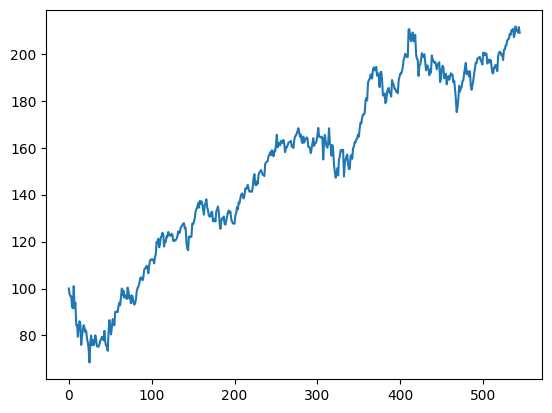

In [90]:
#plt.plot(env.rewardCumulative)
plt.plot(env.netWorthHistory)
#plt.scatter(range(len(env.actionHistory))[:100],env.actionHistory[:100])

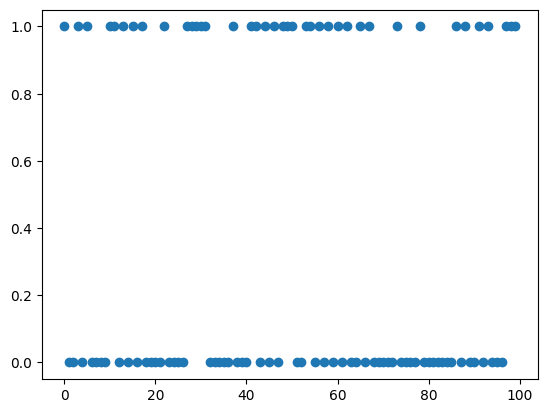

In [91]:
plt.scatter(range(len(env.actionHistory))[:100],env.actionHistory[:100])

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/                 |          |
|    fps                | 103      |
|    iterations         | 100      |
|    time_elapsed       | 4        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.662   |
|    explained_variance | 0.000285 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 1.94     |
|    value_loss         | 7.77     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 111      |
|    iterations         | 200      |
|    time_elapsed       | 8        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.566   |
|    explained_variance | 3.98e-05 |
|    learning_rate      | 0.0007   |
|    n_updates    

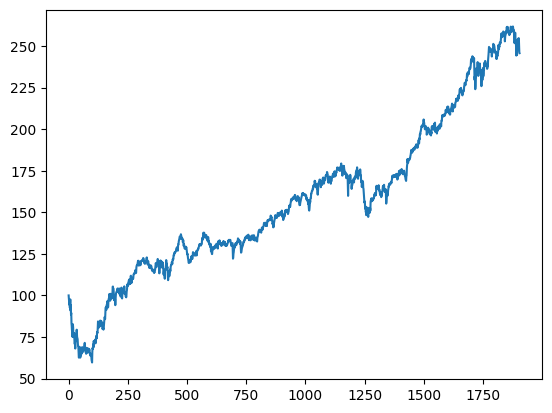

In [98]:
env=train_env()
env.reset()
model=A2C('MlpPolicy',env,verbose=1)
model.learn(total_timesteps=len(allDF)*0.7)
plt.plot(env.netWorthHistory)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


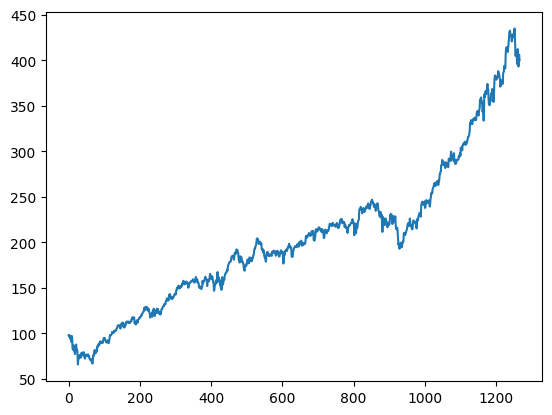

In [99]:
from stable_baselines3 import DQN
env=train_env()
env.reset()
model=DQN('MlpPolicy', env,verbose=1)
model.learn(total_timesteps=len(allDF)*0.7)
plt.plot(env.netWorthHistory)

1267 0 1297


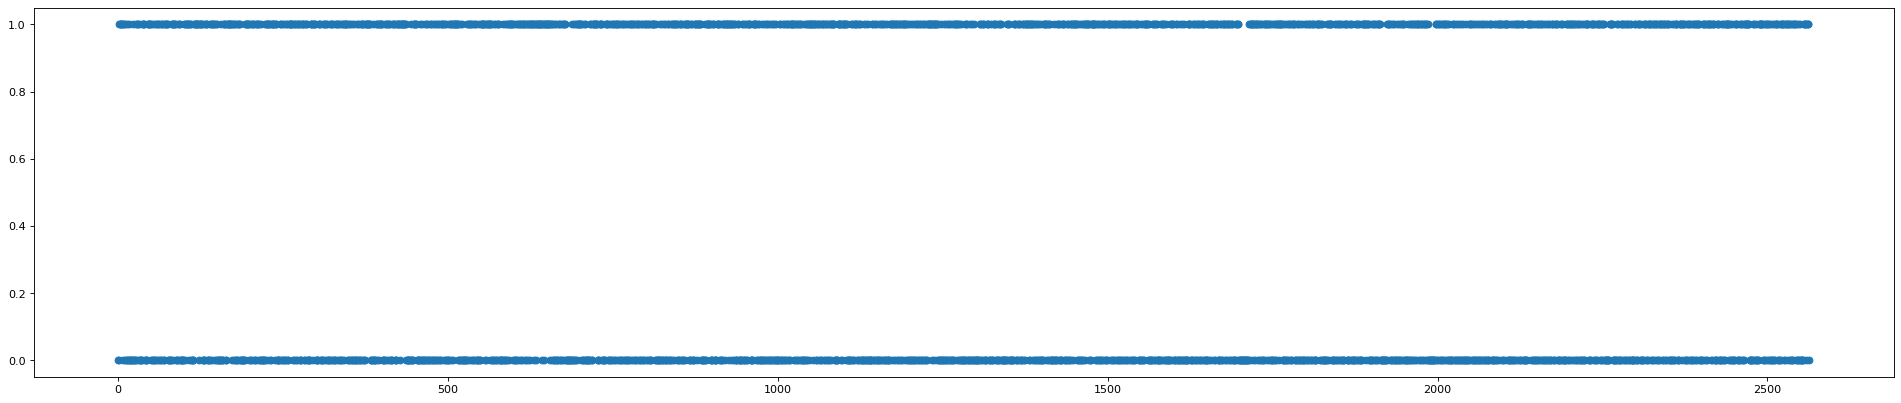

In [111]:
from matplotlib.pyplot import figure
figure(figsize=(30, 6), dpi=80)

plt.scatter(range(len(env.actionHistory)),env.actionHistory)
print(env.action1ct,env.action2ct,env.action3ct)

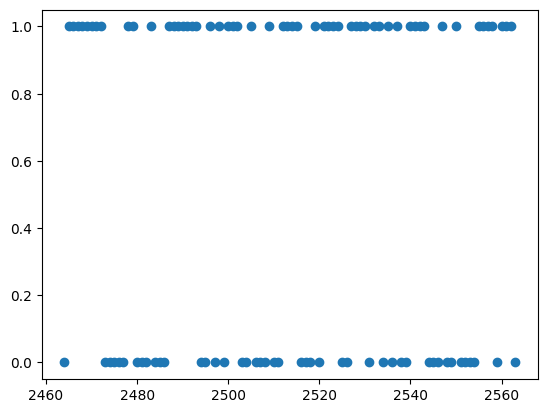

In [101]:
plt.scatter(range(len(env.actionHistory))[-100:],env.actionHistory[-100:])

In [ ]:
day=10
previous_prices=price_train.iloc[day-1].values.tolist()
current_prices=price_train.iloc[day].values.tolist()

previous_shares=[1 for i in range(6)]
shares=previous_shares
    
previous_asset_values=[previous_shares[i]*previous_prices[i] for i in range(6)]
asset_values=[shares[i]*current_prices[i] for i in range(6)]

nw=np.sum(asset_values)
prev_nw=np.sum(previous_asset_values)

reward=1+((nw-prev_nw)/prev_nw)

reward,nw,prev_nw
type(reward)

numpy.float64

In [ ]:
class train_env(gym.Env):
  """Custom Environment that follows gym interface"""
  #metadata = {'render.modes': ['human']}
  def __init__(self):
    super(train_env, self).__init__()
    self.rewardHistory=[]
    self.rewardCumulative=[]

    self.action1ct=0
    self.action2ct=1
    self.action3ct=2

    self.day=5
    self.reward=0
    self.net_worth=100

    sharpe,newWeights,P_ret=findSharpeAndWeights(self.day)
    self.weights=newWeights
    self.previous_prices=price_train.iloc[self.day-1].values.tolist()
    self.current_prices=price_train.iloc[self.day].values.tolist()

    self.previous_shares=self.weightsToShares(self.weights,self.previous_prices)
    self.shares=self.previous_shares
    
    self.previous_asset_values=[self.previous_shares[i]*self.previous_prices[i] for i in range(6)]
    self.asset_values=[self.shares[i]*self.current_prices[i] for i in range(6)]

    self.state=[self.net_worth]+self.shares+self.weights
    self.observations=np.array(all_train.iloc[self.day],dtype=np.float32)
    self.action_space = spaces.Discrete(2) #0, 1, 2
    self.observation_space=spaces.Box(low=-np.inf,high=np.inf,shape=[18])

    self.action=self.get_action()
    self.reset()
    self.step(self.action)

  def reset(self):
    # Reset the state of the environment to an initial state
    self.rewardHistory=[]
    self.rewardCumulative=[]

    self.day=5
    self.reward=0
    self.net_worth=100

    sharpe,newWeights,P_ret=findSharpeAndWeights(self.day)
    self.weights=newWeights 
    self.previous_prices=price_train.iloc[self.day-1].values.tolist()
    self.current_prices=price_train.iloc[self.day].values.tolist()

    self.previous_shares=self.weightsToShares(self.weights,self.previous_prices)
    self.shares=self.previous_shares

    self.previous_asset_values=[self.previous_shares[i]*self.previous_prices[i] for i in range(6)]
    self.asset_values=[self.shares[i]*self.current_prices[i] for i in range(6)]

    self.state=[self.net_worth]+self.shares+self.weights
    self.observations=np.array(all_train.iloc[self.day],dtype=np.float32)
    self.action=self.get_action()
    return self.nextObservations()

  def step(self,action):
    self.done=(self.day>=len(all_train)-1)
    if self.done:
      return self.state,self.reward,self.done, {'info':1}
    else:
      self.take_action(action)
      self.day+=1
      self.state=[self.net_worth]+self.shares+self.weights
      self.previous_prices=price_train.iloc[self.day-1].values.tolist()
      self.current_prices=price_train.iloc[self.day].values.tolist()
      return self.nextObservations(), self.reward, self.done, {'info':1}

  def nextObservations(self):
    day=self.day
    frame=np.array(all_train.iloc[day],dtype=np.float32)
    return frame

  def weightsToShares(self,weights1,current_prices):
    self.weightsValue=[self.net_worth*weights1[i] for i in range(6)]
    shares=[self.weightsValue[i]/current_prices[i] for i in range(6)]
    return shares 

  def take_action(self,action):
    action_type=action
    if action_type==1:
      sharpe,newWeights,P_ret=findSharpeAndWeights(self.day)
      self.previous_shares=self.shares
      self.shares=self.weightsToShares(newWeights,self.current_prices)

      self.previous_asset_values=[self.previous_shares[i]*self.previous_prices[i] for i in range(6)]
      self.asset_values=[self.shares[i]*self.current_prices[i] for i in range(6)]

      nw=np.sum(self.asset_values)
      prev_nw=np.sum(self.previous_asset_values)
      self.reward=1+((nw-prev_nw)/prev_nw)

      self.weights=newWeights
      self.net_worth=self.reward*self.net_worth
      self.action1ct+=1
      return np.float32(self.reward)
      
    else:
      self.previous_asset_values=[self.previous_shares[i]*self.previous_prices[i] for i in range(6)]
      self.asset_values=[self.shares[i]*self.current_prices[i] for i in range(6)]
      nw=np.sum(self.asset_values)
      prev_nw=np.sum(self.previous_asset_values)
      self.reward=1+((nw-prev_nw)/prev_nw)
      self.net_worth=self.reward*self.net_worth
      return np.float32(self.reward)


  def get_action(self):
    #action=1
    #action=rand.randint(0,2) 
    #return action
    pass

In [ ]:
env=train_env()
env.reset()
env.step(1)
env.step(1)
env.step(2)
env.step(3)
env.step(1)
env.previous_shares,env.shares,env.previous_prices,env.current_prices

([2.9792453354070676,
  0.30671703456156746,
  0.3520772725726857,
  0.31241282837104345,
  0.6322835379926827,
  0.004525492524097185],
 [0.5004703165250699,
  0.5179731165572321,
  0.034682980611675324,
  0.5327726585609288,
  0.01782053313628235,
  0.7536858131340421],
 [5.309457, 81.360001, 59.394001, 25.584759, 48.043205, 49.763889],
 [5.28119, 82.18, 60.597652, 26.783403, 47.199917, 49.809551])

In [ ]:
env=train_env()
env.reset()
#env.step(env.action_space.sample())
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=len(all_train)-700)
#env.observation_space.dtype,env.observations.dtype
env.observation_space.shape,env.observations.shape

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 155  |
|    iterations      | 1    |
|    time_elapsed    | 13   |
|    total_timesteps | 2048 |
-----------------------------


ValueError: ignored

In [ ]:
env.reward,env.net_worth

In [ ]:
env.action1ct,env.action2ct,env.action3ct

In [ ]:
plt.plot(env.rewardCumulative)

In [ ]:
class train_env(gym.Env):
  """Custom Environment that follows gym interface"""
  #metadata = {'render.modes': ['human']}
  def __init__(self):
    #super(train_env, self).__init__()
    self.rewardHistory=[]
    self.unweightedRewardHistory=[]
    self.rewardCumulative=[]
    self.actionHistory=[]
    self.action1ct=0
    self.action2ct=0
    self.action3ct=0
    self.day=5
    self.observations=np.array(all_train.iloc[self.day],dtype=np.float32)
    self.action_space = spaces.Discrete(3) #0, 1, 2
    self.observation_space=spaces.Box(low=-np.inf,high=np.inf,shape=[18])
    self.reward=0
    self.net_worth=100
    self.unweighted_net_worth=100
    self.weights=[1/6 for i in range(6)]
    self.current_prices=price_train.iloc[self.day].values.tolist()
    self.shares=self.weightsToSharesBuy(self.weights,self.current_prices)
    self.unweighted_shares=self.weightsToSharesBuy(self.weights,self.current_prices)
    self.asset_values=[self.shares[i]*self.current_prices[i] for i in range(6)]
    self.last_buy_price=[self.current_prices[i] for i in range(6)]
    self.unweighted_buy_price=[self.current_prices[i] for i in range(6)]
    self.state=[self.net_worth]+self.shares+self.asset_values+self.weights
    self.action=self.get_action()
    #self.net_worth=0,self.shares=[1:8],self.asset_values=[8:15],self.weights=[15:22]
    #self.reset()
    self.step(self.action)

  def reset(self):
    # Reset the state of the environment to an initial state
    self.rewardHistory=[]
    self.unweightedRewardHistory=[]
    self.rewardCumulative=[]
    self.actionHistory=[]
    self.action1ct=0
    self.action2ct=0
    self.action3ct=0
    self.day=5
    self.net_worth=100
    self.unweighted_net_worth=100
    self.weights=[1/6 for i in range(6)]
    self.current_prices=price_train.iloc[self.day].values.tolist()
    self.shares=self.weightsToSharesBuy(self.weights,self.current_prices)
    self.unweighted_shares=self.weightsToSharesBuy(self.weights,self.current_prices)
    self.asset_values=[self.weights[i]*self.net_worth for i in range(6)]
    self.last_buy_price=[self.current_prices[i] for i in range(6)]
    self.unweighted_buy_price=[self.current_prices[i] for i in range(6)]
    self.state=[self.net_worth]+self.shares+self.asset_values+self.weights
    self.action=self.get_action()
    self.observation_space=spaces.Box(low=-np.inf,high=np.inf,shape=[18])
    return self.nextObservations()

  def step(self,action):
    self.done=(self.day>=len(all_train)-1)
    if self.done:
      return self.state,self.reward,self.done, {'info':1}
    else:
      self.take_action(action)
      self.unweightedNetWorth()
      self.day+=1
      self.state=[self.net_worth]+self.shares+self.asset_values+self.weights
      self.current_prices=price_train.iloc[self.day].values.tolist()
      self.action=self.get_action()
      self.asset_values=[self.weights[i]*self.net_worth for i in range(6)]
      return self.nextObservations(), self.reward, self.done, {'info':1}

  def nextObservations(self):
    day=self.day
    frame=np.array(all_train.iloc[day],dtype=np.float32)
    return frame

  def render(self, mode='human', close=True):
    pass
    # Render the environment to the screen

  def weightsToSharesBuy(self,weights1,current_prices):
    self.weightsValue=[self.net_worth*weights1[i] for i in range(6)]
    shares=[self.weightsValue[i]/current_prices[i] for i in range(6)]
    return shares 

  def weightChangeToReward(self,weights_diff):
    weights_as_shares=self.weightsToSharesBuy(weights_diff,self.current_prices)
    last_buy_value=[self.shares[i]*self.last_buy_price[i] for i in range(6)]
    current_buy_value=[self.shares[i]*self.current_prices[i] for i in range(6)]
    self.shares=[self.shares[i]+weights_as_shares[i] for i in range(6)]
    self.sell_reward=[current_buy_value[i]-last_buy_value[i] if weights_as_shares[i]<0 else 0 for i in range(6)]
    self.buy_reward=[-current_buy_value[i] if weights_as_shares[i]>0 else 0 for i in range(6)]
    self.reward=np.sum(self.sell_reward)+np.sum(self.buy_reward)
    self.asset_values=[self.shares[i]*self.current_prices[i] for i in range(6)]
    self.net_worth+=self.reward
    self.rewardCumulative.append(self.net_worth)
    self.last_buy_price=[self.current_prices[i] if weights_as_shares[i]>=0 else self.last_buy_price[i] for i in range(6)]
    self.rewardHistory.append(self.reward)
    return self.reward

  def unweightedNetWorth(self):
    last_buy_value=self.unweighted_buy_price
    current_buy_value=[self.unweighted_shares[i]*self.current_prices[i] for i in range(6)]
    unweighted_reward=np.sum(current_buy_value)-np.sum(last_buy_value)
    self.unweighted_net_worth+=unweighted_reward
    return unweighted_reward

  def take_action(self,action):
    action_type=action
    if action_type==1:
      sharpe,newWeights,P_ret=findSharpeAndWeights(self.day)
      weights_diff=[self.weights[i]-newWeights[i] for i in range(6)]
      self.weightChangeToReward(weights_diff)
      self.weights=newWeights
      self.action1ct+=1
      return self.reward
    elif action_type==2:
      newWeights=[1/6 for i in range(6)]
      #weights_diff=[self.weights[i]-newWeights[i] for i in range(6)]
      #self.weightChangeToReward(weights_diff)
      
      self.weights=newWeights
      self.action2ct+=1
      return self.reward
    else:
      #weights_diff=self.weights
      self.action3ct+=1
      weights=self.weights
      sharpe_rwd=sharpe(weights)
      self.reward=self.sharpe
      return self.reward
  def get_action(self):
    #action=1
    #action=rand.randint(0,2) 
    #return action
    pass

In [ ]:
price_test

,AAPLAdj Close,GLDAdj Close,R2KAdj Close,JPMAdj Close,XLEAdj Close,BNDAdj Close
2747,50.283325,133.419998,147.959702,103.170509,50.851639,75.731499
2748,50.458214,133.639999,149.712067,103.625252,50.592396,75.731499
2749,50.929405,134.529999,148.712051,103.295341,50.389866,75.777176
2750,50.710812,134.979996,150.321564,103.063522,50.956955,75.758904
2751,51.745533,133.210007,149.102524,103.429070,50.794922,75.850288
...,...,...,...,...,...,...
3658,157.399994,183.839996,172.812347,126.149971,77.699997,73.218071
3659,159.279999,180.369995,176.000580,129.533417,80.389999,73.018562
3660,157.830002,183.440002,171.009003,126.189659,78.680000,73.666946
3661,158.929993,185.740005,170.250000,125.852303,77.589996,73.836525


In [ ]:
price_test.iloc[5].values.tolist()

[50.625797, 136.410004, 146.940628, 100.700699, 49.644543, 76.393456]

In [ ]:
all_test.iloc[5].values.tolist()

[50.625797,
 136.410004,
 146.940628,
 100.700699,
 49.644543,
 76.393456,
 -2.1876841066556607,
 2.3738202916414237,
 -1.460553582722284,
 -2.673332265021946,
 -2.290791387297247,
 0.7135535298628847,
 2.4248147411872782,
 1.6807638559879385,
 2.26600909416069,
 1.1827388442410236,
 1.7540738186034035,
 0.1747190790293817]

In [ ]:
class test_env(gym.Env):
  """Custom Environment that follows gym interface"""
  #metadata = {'render.modes': ['human']}
  def __init__(self):
    #super(test_env, self).__init__()
    self.rewardHistory=[]
    self.unweightedRewardHistory=[]
    self.rewardCumulative=[]
    self.actionHistory=[]
    self.action1ct=0
    self.action2ct=0
    self.action3ct=0
    self.day=5
    self.observations=np.array(all_test.iloc[self.day],dtype=np.float32)
    self.action_space = spaces.Discrete(3) #0, 1, 2
    self.observation_space=spaces.Box(low=-np.inf,high=np.inf,shape=[18])
    self.reward=0
    self.net_worth=100
    self.unweighted_net_worth=100
    self.weights=[1/6 for i in range(6)]
    self.current_prices=price_test.iloc[self.day].values.tolist()
    self.shares=self.weightsToSharesBuy(self.weights,self.current_prices)
    self.unweighted_shares=self.weightsToSharesBuy(self.weights,self.current_prices)
    self.asset_values=[self.shares[i]*self.current_prices[i] for i in range(6)]
    self.last_buy_price=[self.current_prices[i] for i in range(6)]
    self.unweighted_buy_price=[self.current_prices[i] for i in range(6)]
    self.state=[self.net_worth]+self.shares+self.asset_values+self.weights
    self.action=self.get_action()
    #self.net_worth=0,self.shares=[1:8],self.asset_values=[8:15],self.weights=[15:22]
    self.reset()
    self.step(self.action)

  def reset(self):
    # Reset the state of the environment to an initial state
    self.rewardHistory=[]
    self.unweightedRewardHistory=[]
    self.rewardCumulative=[]
    self.actionHistory=[]
    self.action1ct=0
    self.action2ct=0
    self.action3ct=0
    self.day=5
    self.net_worth=100
    self.unweighted_net_worth=100
    self.weights=[1/6 for i in range(6)]
    self.current_prices=price_test.iloc[self.day].values.tolist()
    self.shares=self.weightsToSharesBuy(self.weights,self.current_prices)
    self.unweighted_shares=self.weightsToSharesBuy(self.weights,self.current_prices)
    self.asset_values=[self.weights[i]*self.net_worth for i in range(6)]
    self.last_buy_price=[self.current_prices[i] for i in range(6)]
    self.unweighted_buy_price=[self.current_prices[i] for i in range(6)]
    self.state=[self.net_worth]+self.shares+self.asset_values+self.weights
    self.action=self.get_action()
    self.observation_space=spaces.Box(low=-np.inf,high=np.inf,shape=[18])
    return self.nextObservations()

  def step(self,action):
    self.done=(self.day>=len(all_test)-1)
    if self.done:
      return self.state,self.reward,self.done, {'info':1}
    else:
      self.take_action(action)
      self.unweightedNetWorth()
      self.day+=1
      self.state=[self.net_worth]+self.shares+self.asset_values+self.weights
      self.current_prices=price_test.iloc[self.day].values.tolist()
      self.action=self.get_action()
      self.asset_values=[self.weights[i]*self.net_worth for i in range(6)]
      return self.nextObservations(), self.reward, self.done, {'info':1}

  def nextObservations(self):
    day=self.day
    frame=np.array(all_test.iloc[day],dtype=np.float32)
    return frame

  def render(self, mode='human', close=True):
    pass
    # Render the environment to the screen

  def weightsToSharesBuy(self,weights1,current_prices):
    self.weightsValue=[self.net_worth*weights1[i] for i in range(6)]
    shares=[self.weightsValue[i]/current_prices[i] for i in range(6)]
    return shares 

  def weightChangeToReward(self,weights_diff):
    weights_as_shares=self.weightsToSharesBuy(weights_diff,self.current_prices)
    last_buy_value=[self.shares[i]*self.last_buy_price[i] for i in range(6)]
    current_buy_value=[self.shares[i]*self.current_prices[i] for i in range(6)]
    self.shares=[self.shares[i]+weights_as_shares[i] for i in range(6)]
    self.reward=np.sum(current_buy_value)-np.sum(last_buy_value)
    self.reward=self.reward*0.95
    self.asset_values=[self.shares[i]*self.current_prices[i] for i in range(6)]
    self.net_worth+=self.reward
    self.rewardCumulative.append(self.net_worth)
    self.last_buy_price=[self.current_prices[i] if weights_as_shares[i]!=0 else self.last_buy_price[i] for i in range(6)]
    self.rewardHistory.append(self.reward)
    return self.reward

  def unweightedNetWorth(self):
    last_buy_value=self.unweighted_buy_price
    current_buy_value=[self.unweighted_shares[i]*self.current_prices[i] for i in range(6)]
    unweighted_reward=np.sum(current_buy_value)-np.sum(last_buy_value)
    self.unweighted_net_worth+=unweighted_reward
    return unweighted_reward

  def take_action(self,action):
    action_type=action
    if action_type==1:
      sharpe,newWeights,P_ret=findSharpeAndWeights(self.day)
      weights_diff=[self.weights[i]-newWeights[i] for i in range(6)]
      self.weightChangeToReward(weights_diff)
      self.weights=newWeights
      self.action1ct+=1
      return self.reward
    elif action_type==2:
      newWeights=[1/6 for i in range(6)]
      weights_diff=[self.weights[i]-newWeights[i] for i in range(6)]
      self.weightChangeToReward(weights_diff)
      self.weights=newWeights
      self.action2ct+=1
      return self.reward
    else:
      weights_diff=self.weights
      self.action3ct+=1
      return self.reward
  def get_action(self):
    #action=1
    #action=rand.randint(0,2) 
    #return action
    pass

In [ ]:
test_env=test_env()
episodes = 10
rewardList=[]
for ep in range(episodes):
  test_env.reset()
  obvs=test_env.reset()
  done=False
  while done == False:
    action,_states=model.predict(obvs)
    obvs,rewards,done,info=test_env.step(action)
    print('NW',test_env.net_worth)
  rewardList.append(test_env.net_worth)

Streaming output truncated to the last 5000 lines.
NW 112.64413565294193
NW 112.64413565294193
NW 115.00837207565536
NW 115.36419549380948
NW 115.87606698032394
NW 116.04978320088897
NW 116.00271376390879
NW 116.00271376390879
NW 112.91455049605338
NW 112.91455049605338
NW 112.7756979877899
NW 112.72876262088317
NW 113.26781792500913
NW 113.97431127390765
NW 113.75826250095662
NW 113.74366484573237
NW 114.34305750190705
NW 114.34305750190705
NW 114.34305750190705
NW 116.17445199613444
NW 117.01407274803933
NW 116.014128567801
NW 118.06704901905498
NW 117.93195219050665
NW 117.93195219050665
NW 117.89736878101367
NW 117.34857926085432
NW 117.34857926085432
NW 112.41642628957777
NW 109.97967622671605
NW 108.3599603520554
NW 108.0025985694708
NW 108.58939445135064
NW 108.58939445135064
NW 108.58939445135064
NW 108.58939445135064
NW 109.54645062588583
NW 109.54645062588583
NW 108.36263819352384
NW 109.45790302221114
NW 109.54272136265166
NW 109.54272136265166
NW 109.54272136265166
NW 110.9

In [ ]:
test_env.net_worth, rewardList

(144.1114313222557,
 [199.41356065388496,
  245.31252435401242,
  428.3017205710454,
  270.5352478982905,
  343.89450876602194,
  214.1197542366506,
  215.4601401691484,
  302.42938237061617,
  254.41180088577855,
  144.1114313222557])

In [ ]:
policy = EpsGreedyQPolicy()
memory = SequentialMemory(limit=50, window_length=1)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this slows down training quite a lot. 
dqn.fit(env, nb_steps=5, visualize=True, verbose=2)

In [ ]:
dqn.test(env, nb_episodes=5, visualize=True)

In [ ]:
#!pip uninstall gym

Found existing installation: gym 0.23.0
Uninstalling gym-0.23.0:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/gym-0.23.0.dist-info/*
    /usr/local/lib/python3.9/dist-packages/gym/*
Proceed (Y/n)? Y
  Successfully uninstalled gym-0.23.0


In [ ]:
!pip install gym==0.23.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.2/626.2 kB 12.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.23.1-py3-none-any.whl size=701374 sha256=e23a6e333bd2d9feba8689d67781ba70610ed4956ad715beb779d000574c2491
  Stored in directory: /root/.cache/pip/wheels/4e/be/7e/92a54668db96883e38ce60a9249dc55de7cd6eee49e7311940
Successfully built gym
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-agents 0.16.0 requires gym<=0.23.0,>=0.17.0, but you have gym 0.23.1 which is incompatible.


In [ ]:
def value_function(state):
    n_hidden1 = 400  
    n_hidden2 = 400
    n_outputs = 1
    with tf.variable_scope("value_network"):
        init_xavier = tf.contrib.layers.xavier_initializer()
        
        hidden1 = tf.layers.dense(state, n_hidden1, tf.nn.elu, 
                                  init_xavier)
        hidden2 = tf.layers.dense(hidden1, n_hidden2, tf.nn.elu, 
                                  init_xavier) 
        V = tf.layers.dense(hidden2, n_outputs, None, init_xavier)
    return V
def policy_network(state):
    n_hidden1 = 40
    n_hidden2 = 40
    n_outputs = 1
    
    with tf.variable_scope("policy_network"):
        init_xavier = tf.contrib.layers.xavier_initializer()
        
        hidden1 = tf.layers.dense(state, n_hidden1, 
                                  tf.nn.elu, init_xavier)
        hidden2 = tf.layers.dense(hidden1, n_hidden2, 
                                  tf.nn.elu, init_xavier)
        mu = tf.layers.dense(hidden2, n_outputs, 
                             None, init_xavier)
        sigma = tf.layers.dense(hidden2, n_outputs, 
                                None, init_xavier)
        sigma = tf.nn.softplus(sigma) + 1e-5
        norm_dist = tf.contrib.distributions.Normal(mu, sigma)
        action_tf_var = tf.squeeze(norm_dist.sample(1), axis=0)
        action_tf_var = tf.clip_by_value(action_tf_var, 
                                         env.action_space.low[0], 
                                         env.action_space.high[0])
    return action_tf_var, norm_dist

# rewrite but should run

In [ ]:
# Ornstein-Ulhenbeck Process
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu  
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)
class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)
    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []
        batch = random.sample(self.buffer, batch_size)
        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch
    def __len__(self):
        return len(self.buffer)

# change to fit

In [ ]:
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """
    def _action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b
    def _reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

In [ ]:
from tf_agents.agents.ddpg import critic_network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.autograd
from torch.autograd import Variable

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size) 
    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x

In [ ]:
import torch
import torch.autograd
import torch.optim as optim
import torch.nn as nn
from model import *
from utils import *

class DDPGagent:
    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=50000):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Training
        self.memory = Memory(max_memory_size)        
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)
    
    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        return action
    
    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
    
        # Critic loss        
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()

        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

In [ ]:

import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DDPG import DDPGagent
from utils import *

env = NormalizedEnv(gym.make("Pendulum-v0"))

agent = DDPGagent(env)
noise = OUNoise(env.action_space)
batch_size = 128
rewards = []
avg_rewards = []

for episode in range(50):
    state = env.reset()
    noise.reset()
    episode_reward = 0
    
    for step in range(500):
        action = agent.get_action(state)
        action = noise.get_action(action, step)
        new_state, reward, done, _ = env.step(action) 
        agent.memory.push(state, action, reward, new_state, done)
        
        if len(agent.memory) > batch_size:
            agent.update(batch_size)        
        
        state = new_state
        episode_reward += reward

        if done:
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [ ]:
observation_space=train_env.observation_space()
action_space=train_env.action_space()
critic_net=critic_network.CriticNetwork(
    (observation_space,action_space),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=critic_joint_fc_layer_params)
)

In [ ]:
weights=[0.5,0.5]

In [ ]:
def portfolio(returns,weights):
  weights=np.array(weights)
  rets=returns.mean()*252
  covs=returns.cov()*252
  P_ret=np.sum(rets*weights)
  P_vol=np.sqrt(np.dot(weights.T,np.dot(covs,weights)))
  P_sharpe=P_ret/P_vol
  return np.array([P_ret,P_vol,P_sharpe])

def local_portfolio(returns,weights):
  weights=np.array(weights)
  rets=returns.mean()*252
  covs=returns.cov()*252
  P_ret=np.sum(rets*weights)
  P_vol=np.sqrt(np.dot(weights.T,np.dot(covs,weights)))
  P_sharpe=P_ret/P_vol
  return np.array([P_ret,P_vol,P_sharpe])

In [ ]:
SPY=pd.read_csv('/content/drive/MyDrive/data/portfolio_index/SPY.csv')
ARKK=pd.read_csv('/content/drive/MyDrive/data/portfolio_index/ARKK.csv')
priceDF=SPY[['Date','Adj Close']]
arkk=ARKK[['Date','Adj Close']]
priceDF=priceDF.merge(arkk,on='Date')
priceDF.index=priceDF['Date']
priceDF=priceDF.drop(columns='Date')
priceDF

,Adj Close_x,Adj Close_y
Date,,
2018-03-29,241.652130,36.816261
2018-04-02,236.436142,35.628944
2018-04-03,239.466522,36.137791
2018-04-04,242.028625,37.004726
2018-04-05,243.938705,37.249725
...,...,...
2023-03-22,392.109985,38.389999
2023-03-23,393.170013,37.799999
2023-03-24,395.750000,37.730000


In [ ]:
data_period = priceDF[1:5]
weights = [0.5,0.5]
returns = data_period.pct_change().dropna()
sharpe = local_portfolio(returns, weights)[-1]

In [ ]:
class Agent:
    
    def __init__(
                     self, 
                     portfolio_size,
                     is_eval = False, 
                     allow_short = True,
                 ):
        
        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        self.input_shape = (portfolio_size, portfolio_size, )
        self.action_size = 3 # sit, buy, sell
        
        self.memory4replay = []
        self.is_eval = is_eval

        self.alpha = 0.5
        self.gamma = 0.95
        self.epsilon = 1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.state=env.get_state(np.random.randint(window_size+1, data_length-window_size-1), window_size)
        self.model = self._model(self.state)

    def _model(self,state):
        
        inputs = Input(shape=self.input_shape)        
        x = Flatten()(inputs)
        x = Dense(100, activation='elu')(x)
        x = Dropout(0.5)(x)
        x = Dense(50, activation='elu')(x)
        x = Dropout(0.5)(x)
        
        predictions = []
        for i in range(self.portfolio_size):
            asset_dense = Dense(self.action_size, activation='linear')(x)   
            predictions.append(asset_dense)
        
        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer='adam', loss='mse')
        return model

    def nn_pred_to_weights(self, pred, allow_short = False):

        weights = np.zeros(len(pred))
        raw_weights = np.argmax(pred, axis=-1)

        saved_min = None
        
        for e, r in enumerate(raw_weights):
            if r == 0: # sit
                weights[e] = 0
            elif r == 1: # buy
                weights[e] = np.abs(pred[e][0][r])
            else:
                weights[e] = -np.abs(pred[e][0][r])
        #sum of absolute values in short is allowed
        if not allow_short:
            weights += np.abs(np.min(weights))
            saved_min = np.abs(np.min(weights))
            saved_sum = np.sum(weights)
        else:
            saved_sum = np.sum(np.abs(weights))
            
        weights /= saved_sum
        return weights, saved_min, saved_sum
    #return the action based on the state, uses the NN function 
    def act(self, state):
        
        if not self.is_eval and random.random() <= self.epsilon:
            w = np.random.normal(0, 1, size = (self.portfolio_size, ))  
              
            saved_min = None
            
            if not self.allow_short:
                w += np.abs(np.min(w))
                saved_min = np.abs(np.min(w))
                
            saved_sum = np.sum(w)
            w /= saved_sum
            return w , saved_min, saved_sum
        fit=self.model.fit()
        pred = self.model.predict(np.expand_dims(state.values, 0))
        return self.nn_pred_to_weights(pred, self.allow_short)

    def expReplay(self, batch_size):

        def weights_to_nn_preds_with_reward(action_weights, 
                                            reward, 
                                            Q_star = np.zeros((self.portfolio_size, self.action_size))): 
            
            Q = np.zeros((self.portfolio_size, self.action_size))           
            for i in range(self.portfolio_size):
                if action_weights[i] == 0:
                    Q[i][0] = reward[i] + self.gamma * np.max(Q_star[i][0])
                elif action_weights[i] > 0:
                    Q[i][1] = reward[i] + self.gamma * np.max(Q_star[i][1])
                else:
                    Q[i][2] = reward[i] + self.gamma * np.max(Q_star[i][2])            
            return Q  
        
        def restore_Q_from_weights_and_stats(action):            
            action_weights, action_min, action_sum = action[0], action[1], action[2]
            action_weights = action_weights * action_sum          
            if action_min != None:
                action_weights = action_weights - action_min   
            return action_weights
        
        for (s, s_, action, reward, done) in self.memory4replay:
            
            action_weights = restore_Q_from_weights_and_stats(action) 
            #Reward =reward if not in the terminal state. 
            Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward)
            s, s_ = s.values, s_.values    

            if not done:
                # reward + gamma * Q^*(s_, a_)
                Q_star = self.model.predict(np.expand_dims(s_, 0))
                Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward, np.squeeze(Q_star))  

            Q_learned_value = [xi.reshape(1, -1) for xi in Q_learned_value]
            Q_current_value = self.model.predict(np.expand_dims(s, 0))
            Q = [np.add(a * (1-self.alpha), q * self.alpha) for a, q in zip(Q_current_value, Q_learned_value)]
            
            # update current Q function with new optimal value
            self.model.fit(np.expand_dims(s, 0), Q, epochs=1, verbose=0)            
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 

In [ ]:
N_ASSETS = 2 #53
s = env.get_state(np.random.randint(window_size+1, data_length-window_size-1), window_size)
agent = Agent(N_ASSETS,s)
env = CryptoEnvironment()
window_size = 10
episode_count = 500
batch_size = 32
rebalance_period = 10 #every 90 days weight change
data_length = len(env.data)
data_length
np.random.randint(window_size+1, data_length-window_size-1)

599

Episode 0/500 epsilon 1
1/1 [==============================] - 0s 20ms/step


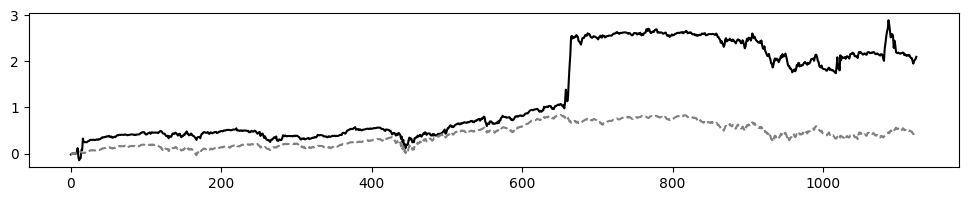

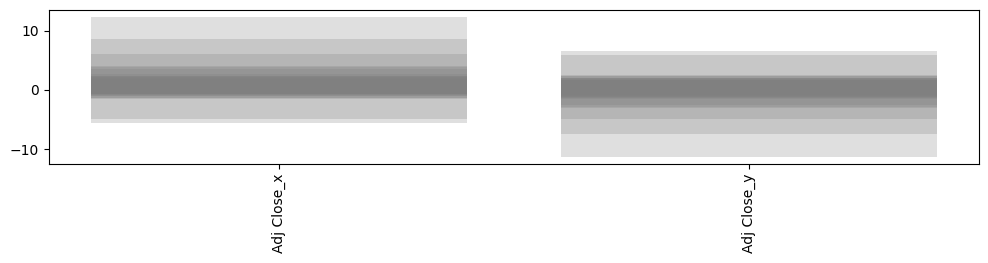

Episode 1/500 epsilon 0.9702989999999999
1/1 [==============================] - 0s 29ms/step


ValueError: ignored

In [ ]:
for e in range(episode_count):
    
    agent.is_eval = False
    data_length = len(env.data)
    
    returns_history = []
    returns_history_equal = []
    
    rewards_history = []
    equal_rewards = []
    
    actions_to_show = []
    
    print("Episode " + str(e) + "/" + str(episode_count), 'epsilon', agent.epsilon)

    s = env.get_state(np.random.randint(window_size+1, data_length-window_size-1), window_size)
    total_profit = 0 

    for t in range(window_size, data_length, rebalance_period):
        date1 = t-rebalance_period
        #correlation from 90-180 days 
        s_ = env.get_state(t, window_size)
        action = agent.act(s_)
        
        actions_to_show.append(action[0])
        
        weighted_returns, reward = env.get_reward(action[0], date1, t)
        weighted_returns_equal, reward_equal = env.get_reward(
            np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

        rewards_history.append(reward)
        equal_rewards.append(reward_equal)
        returns_history.extend(weighted_returns)
        returns_history_equal.extend(weighted_returns_equal)

        done = True if t == data_length else False
        agent.memory4replay.append((s, s_, action, reward, done))
        
        if len(agent.memory4replay) >= batch_size:
            agent.expReplay(batch_size)
            agent.memory4replay = []
            
        s = s_

    rl_result = np.array(returns_history).cumsum()
    equal_result = np.array(returns_history_equal).cumsum()

    plt.figure(figsize = (12, 2))
    plt.plot(rl_result, color = 'black', ls = '-')
    plt.plot(equal_result, color = 'grey', ls = '--')
    plt.show()
    
    plt.figure(figsize = (12, 2))
    for a in actions_to_show:    
        plt.bar(np.arange(N_ASSETS), a, color = 'grey', alpha = 0.25)
        plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')
    plt.show()

# https://towardsdatascience.com/deep-deterministic-policy-gradients-explained-2d94655a9b7b

In mathematics, the Ornstein–Uhlenbeck process is a stochastic process with applications in financial mathematics and the physical sciences.

# https://github.com/kvsnoufal/portfolio-optimization

In [ ]:
#vix=pd.read_csv('/content/drive/MyDrive/data/15_MIN_HIST/vix-15m.csv',sep=';')
#columns: data,open,high,low,close,volume
#vix

In [ ]:
# Ornstein-Ulhenbeck Process
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu  
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

In [ ]:
# https://github.com/openai/gym/blob/master/gym/core.py
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """
    def _action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b
    def _reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)
    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []
        batch = random.sample(self.buffer, batch_size)
        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch
    def __len__(self):
        return len(self.buffer)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.autograd
from torch.autograd import Variable

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size) 
    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x

In [ ]:
import torch
import torch.autograd
import torch.optim as optim
import torch.nn as nn
from model import *
from utils import *

class DDPGagent:
    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=50000):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Training
        self.memory = Memory(max_memory_size)        
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)
    
    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        return action
    
    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
    
        # Critic loss        
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()

        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

ModuleNotFoundError: ignored

In [ ]:

import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DDPG import DDPGagent
from utils import *

env = NormalizedEnv(gym.make("Pendulum-v0"))

agent = DDPGagent(env)
noise = OUNoise(env.action_space)
batch_size = 128
rewards = []
avg_rewards = []

for episode in range(50):
    state = env.reset()
    noise.reset()
    episode_reward = 0
    
    for step in range(500):
        action = agent.get_action(state)
        action = noise.get_action(action, step)
        new_state, reward, done, _ = env.step(action) 
        agent.memory.push(state, action, reward, new_state, done)
        
        if len(agent.memory) > batch_size:
            agent.update(batch_size)        
        
        state = new_state
        episode_reward += reward

        if done:
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

ModuleNotFoundError: ignored

In [ ]:
originalDF=df
df=df.dropna() 

columnList=['rain', 'humidity', 'temperature']
newDataFrames=[]
for column in columnList:
  columnDF=pd.DataFrame()
  columnDF=df[['Date',column]]
  newDataFrames.append(columnDF)
newDataFrames[i] # this should return the rain dataframe